# Problem Set 3

# Student: Alejandro Rojas

# Code and Program Set Up

In [77]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.2.0")

Activated /home/jupyter/Computational Economics - My codes/Project.toml
Info Project name is quantecon-notebooks-julia, version is 0.2.0


In [78]:
using LinearAlgebra, Statistics
using QuantEcon, QuadGK, FastGaussQuadrature, Distributions, Expectations
using Interpolations, Plots, LaTeXStrings, ProgressMeter

ArgumentError: ArgumentError: Package QuantEcon [fcd29c91-0bd7-5a09-975d-7ac3f643a60c] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


# Exercise 4 in Introduction to Types

## Problem

Use your solution to Exercise 8(a/b) in [Introductory Examples](https://lectures.quantecon.org/julia_by_example.html) to
create a specialized version of Newton’s method for `Polynomials` using the `polyder` function

The signature of the function should be `newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)`,
where `p::Poly` ensures that this version of the function will be used anytime a polynomial is passed (i.e. dispatch)

Compare the results of this function to the built-in `roots(p)` function

## Solution

In [79]:
using Polynomials, LinearAlgebra
function newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)
    x_old = x_0
    normdiff = Inf
    iter = 1
    p_primes = polyder(p)
    while normdiff >  tolerance && iter <= maxiter
        x_new = x_old - (p(x_old)/p_primes(x_old))
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    return (value = x_old, normdiff = normdiff, iter = iter)
end

newtonsmethod (generic function with 1 method)

In [80]:
using Polynomials
p = Poly([2, -5, 2], :x)
newtonsmethod(p,3)

(value = 2.0, normdiff = 2.76667577736589e-13, iter = 7)

In [81]:
using Polynomials
p = Poly([2, -5, 2], :x)
newtonsmethod(p,0)

(value = 0.5, normdiff = 3.4924596548080444e-10, iter = 6)

While `newtonsmethod` is going to give one root, `roots` will give all the roots of the polynomial. In the case of the polynomial $p(x) = 2 -5 x+2x^2$ we see that $x=0$ and $x=2$ are roots, but we only get one of these results with the function `newtonsmethod`, while with `roots` we obtain both. 

# Exercise 5 in Introduction to Types

## Problem

The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)  approximates an integral with

$$
\int_\underline{x}^\bar{x} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = \underline{x},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $

Given an `x` and a function `f`, implement a few variations of the trapezoidal rule using multiple dispatch

- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`  
- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`
  * Exploit the fact that `AbstractRange` has constant step sizes to specialize the algorithm  
- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`
  * For this, build a uniform grid with `N` points on `[x̲, x̄]` – call the `f` function at those grid points and use the existing `trapezoidal(f, x)` from the implementation  


With these:
1. Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $
2. From the analytical solution of the function, plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different `N` values
3. Consider trying different functions for $ f(x) $ and compare the solutions for various `N`

When trying different functions, instead of integrating by hand consider using a high-accuracy
library for numerical integration such as [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/latest/)

## Solution

**First case**: `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)` 

In [82]:
function trapezoidal1(f::AbstractArray, x::AbstractArray)
    int = 0;
    for i ∈ 2:length(x)
        int = int + ((f[i,1]+f[i-1,1])/2)*(x[i,1]-x[i-1,1])
    end
    return int
end

trapezoidal1 (generic function with 1 method)

In [83]:
f(x) = x.^2;
xl = 0;
xu = 1;
N = 100;
gap = norm(xu-xl)/(N-1);

x  = collect(xl:gap:xu);
r = f(x);
sol = trapezoidal1(r,x);

println("With lower bound $(xl) and upper bound $(xu) the trapezoidal integration is $(sol).")

With lower bound 0 and upper bound 1 the trapezoidal integration is 0.33335033840084344.


**Second case**: `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`

In [84]:
function trapezoidal2(f::AbstractArray, y::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}})
    int = 0;
    for i ∈ 2:length(x)
        int = int + ((f[i,1]+f[i-1,1])/2)*(x[i,1]-x[i-1,1]);
    end
    return int
end

trapezoidal2 (generic function with 2 methods)

In [85]:
xl = 0;
xu = 1;
N = 100;
gap = norm(xu-xl)/(N-1);

x  = xl:gap:xu;
r = [s^2 for s ∈ x];
sol = trapezoidal2(r, x);
println("With lower bound $(xl) and upper bound $(xu) the trapezoidal integration is $(sol).")

With lower bound 0 and upper bound 1 the trapezoidal integration is 0.33335033840084344.


**Third case**: `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`

In [86]:
function trapezoidal(f::Function, xl::Real, xu::Real, N::Real)
    gap = norm(xu-xl)/(N-1);
    x = collect(xl:gap:xu);
    r = f.(x)
    int = 0;
    for i ∈ 2:length(x)
        int += ((r[i,1]+r[i-1,1])/2)*(x[i,1]-x[i-1,1]);
    end
    return int
end

trapezoidal (generic function with 1 method)

In [87]:
f(x) = x.^2;
trapezoidal(f, 0, 1, 10)

0.3353909465020576

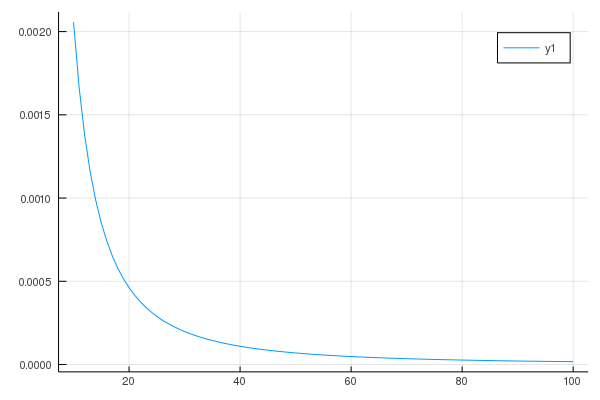

In [88]:
using QuadGK
f(x) = x.^2;
int = quadgk(f, 0, 1, rtol=1e-10);
N = collect(10:100);
Y = zeros(size(N)[1],1);
count = 1;
for n ∈ N
    Y[count,1] = trapezoidal(f, 0, 1, n) - int[1];
    count = count + 1;
end

using Plots
plot(N, Y)

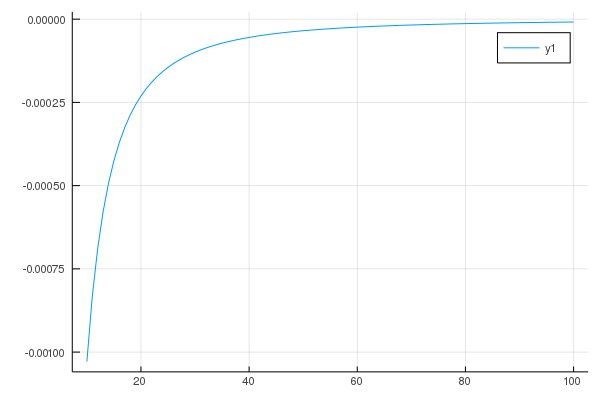

In [89]:
using QuadGK
f(x) = x.^3-2*x.^2;
int = quadgk(f, 0, 1, rtol=1e-10);
N = collect(10:100);
Y = zeros(size(N)[1],1);
count = 1;
for n ∈ N
    Y[count,1] = trapezoidal(f, 0, 1, n) - int[1];
    count = count + 1;
end

using Plots
plot(N, Y)

# Exercise 6 in Introduction to Types

## Problem

Take a variation of your code in Exercise 5

Use auto-differentiation to calculate the following derivative for the example functions

$$\frac{d}{d \bar{x}}\int_\underline{x}^\bar{x} f(x) \, dx$$

Hint: See the following code for the general pattern, and be careful to
follow the [rules for generic programming](#generic-tips-tricks)

In [90]:
using ForwardDiff

function f(a, b; N = 50)
    r = range(a, b, length=N) # one
return mean(r)
end

Df(x) = ForwardDiff.derivative(y -> f(0.0, y), x)

@show f(0.0, 3.0)
@show f(0.0, 3.1)

Df(3.0)

f(0.0, 3.0) = 1.5
f(0.0, 3.1) = 1.55


0.5

## Solution

In this problem I ran with an issue. For some reason that I do not understand. My function trapezoidal doesn't work with ForwardDiff. My impression after trying to solve this error for a while is that there is a type problem with my function that doesn't allow ForwardDiff to pass through. 

In [99]:
using ForwardDiff

function trapezoidal(f::Function, xl::Real, xu::Real, N::Real)
    gap = norm(xu-xl)/(N-1);
    x = collect(xl:gap:xu);
    int = 0.0;
    for i ∈ 2:length(x)
        int += ((f(x[i,1])+f(x[i-1,1]))/2)*gap;
    end
    return int
end

function trapezoidal2(f::Function, xinit::Real , xupper::Real ,  N::Real)
    M = length(xupper)
    Δ = (xupper-xinit)/(N-1)
    total = zero(eltype(xinit))
    x=xinit
    
    for i=1:N
        weight = ((i == 1) || (i == N)) ?  Δ/2 : Δ  
        total += weight * f(x)
        x += Δ
    end
    return total
end

pe(x) = x^2;
xl = 0.0;
N = 100.0;

Df(s) = ForwardDiff.derivative(y -> trapezoidal2(pe,xl, y, N), s)

@show trapezoidal2(pe, xl, 1.0,N)
@show trapezoidal2(pe, xl, 1.1,N)

@show Df(1.0)

Dfr(s) = ForwardDiff.derivative(y -> trapezoidal(pe,xl, y, N), s)

@show trapezoidal(pe, xl, 1.0,N)
@show trapezoidal(pe, xl, 1.1,N)

@show Dfr(1.0)


trapezoidal2(pe, xl, 1.0, N) = 0.33335033840084294
trapezoidal2(pe, xl, 1.1, N) = 0.44368930041152177
Df(1.0) = 1.0000510152025281
trapezoidal(pe, xl, 1.0, N) = 0.3333503384008435
trapezoidal(pe, xl, 1.1, N) = 0.4436893004115227


MethodError: MethodError: no method matching Integer(::ForwardDiff.Dual{ForwardDiff.Tag{getfield(Main, Symbol("##119#120")),Float64},Float64,1})
Closest candidates are:
  Integer(::T<:Number) where T<:Number at boot.jl:718
  Integer(!Matched::Integer) at boot.jl:743
  Integer(!Matched::Union{Float32, Float64}) at boot.jl:744
  ...